In [2]:
import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['OMP_NUM_THREADS'] = '4'


import torch

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def fourier_features(x, max_degree):
    features = []
    for i in range(max_degree):
        features.append(torch.sin((i + 1) * x))
        features.append(torch.cos((i + 1) * x))
    feats = torch.cat(features, dim=1)
    return feats

def synthetic_data(max_degree, N, noise_std):
    coeffs = torch.randn(2 * max_degree)
    # uniform sampling
    x = torch.rand(N, 1) * 2 * np.pi
    y = torch.mm(fourier_features(x, max_degree), coeffs.unsqueeze(1))
    y += torch.randn(N, 1) * noise_std
    return x, y, coeffs



def train(x, y, max_degree, N, noise_std, epochs=2000, lr=0.01):
    x_fourier = fourier_features(x, max_degree)
    model = torch.nn.Linear(2 * max_degree, 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(epochs):
        y_pred = model(x_fourier)
        loss = loss_fn(y_pred, y) / (2 * noise_std ** 2)
        # add weight decay
        for param in model.parameters():
            loss += torch.sum(param ** 2) / N
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model

max_degree = 10
noise_std = 1
N = 20
# SET SEED
torch.manual_seed(0)

x, y, true_coeffs = synthetic_data(max_degree, N, noise_std)
model = train(x, y, max_degree, N, noise_std)


In [3]:
import seaborn as sns
sns.set_style('whitegrid')
sns.color_palette('Set1')

def plot(x, y, model, max_degree, true_coeffs):
    plt.scatter(x, y, s=10, label='Observations', color='red')
    x_test = torch.linspace(0, 2 * np.pi, 1000).unsqueeze(1)
    y_pred = model(fourier_features(x_test, max_degree))
    y_true = torch.mm(fourier_features(x_test, max_degree), true_coeffs.unsqueeze(1))
    plt.plot(x_test, y_pred.detach(), label='Learned')
    # plt.plot(x_test, y_true, label='True function')
    plt.legend()
    plt.show()


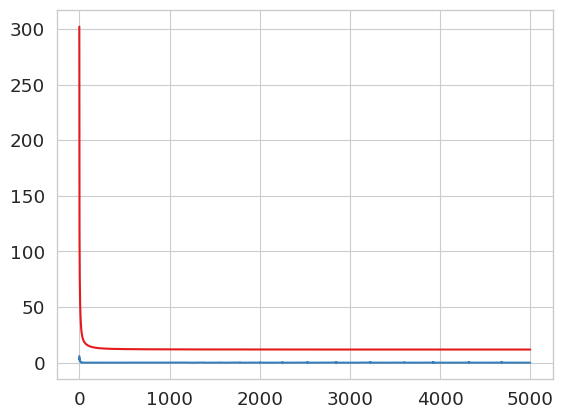

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def rbf_features(x, num_rbf):
    # RBF function
    def rbf(x, c, h):
        return torch.exp(-(x - c) ** 2 / h)
    cs = torch.linspace(0, 1, num_rbf)
    h = cs[1] - cs[0]
    feats = [rbf(x, c, h) for c in cs]
    feats = torch.cat(feats, dim=1)
    return feats

def synthetic_data(max_degree, N):
    coeffs = torch.randn(2 * max_degree)
    # uniform sampling
    x = torch.rand(N, 1) 
    y = torch.mm(fourier_features(x, max_degree), coeffs.unsqueeze(1))
    y += torch.randn(N, 1) * 1
    return x, y, coeffs

def train(x, y, max_degree, N, noise_std, neg_log_prior, epochs=5000, lr=0.1):
    x_poly = rbf_features(x, max_degree)
    model = torch.nn.Linear(max_degree, 1, bias=True)
    # zero initialization
    # model.weight.data.zero_()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        y_pred = model(x_poly)
        loss = loss_fn(y_pred, y) / (2 * noise_std ** 2)
        # add weight decay
        loss += neg_log_prior(model) / N
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    plt.plot(losses)
    return model

def neg_log_gaussian_prior(model, sigma=1):
    # Gaussian prior
    neg_log_prior = 0
    for param in model.parameters():
        neg_log_prior += torch.sum(param ** 2)
    neg_log_prior /= 2 * sigma ** 2
    return neg_log_prior

def inverted_neg_log_gaussian_prior(model, sigma=1):
    # Gaussian prior
    neg_log_prior = 0
    for param in model.parameters():
        neg_log_prior += torch.sum(param ** 2)
    neg_log_prior /= 2 * sigma ** 2
    logdet = - 2 * torch.sum(torch.log(torch.abs(model.weight + 1e-8)))
    neg_log_prior += logdet
    return neg_log_prior

# data
max_freqs = 20
# model
max_degree = 1000
noise_std = 1
N = 30

# SET SEED
torch.manual_seed(0)

x, y, true_coeffs = synthetic_data(max_freqs, N)
# model = train(x, y, max_degree, N, noise_std, neg_log_gaussian_prior)
inverted_model = train(x, y, max_degree, N, noise_std, inverted_neg_log_gaussian_prior)
model = train(x, y, max_degree, N, noise_std, neg_log_gaussian_prior)


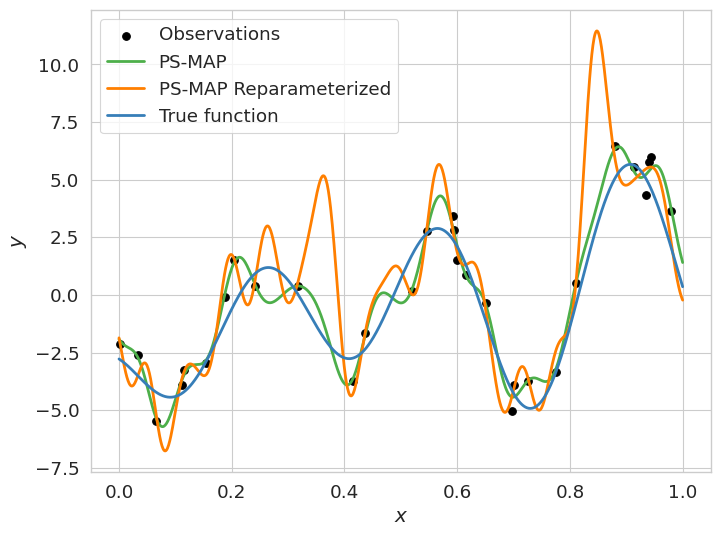

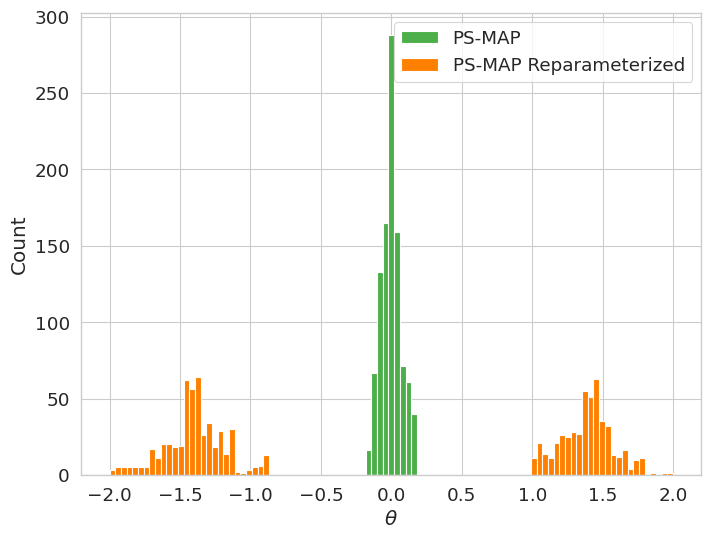

In [17]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2})
sns.set_palette("Set1")

def plot(x, y, model, inverted_model, max_freqs, max_degree, true_coeffs):
    plt.figure(figsize=(8, 6), dpi=100)
    plt.scatter(x, y, s=30, label='Observations', color='black')
    x_test = torch.linspace(0, 1, 1000).unsqueeze(1)
    y_pred = model(rbf_features(x_test, max_degree))
    y_pred_inverted = inverted_model(rbf_features(x_test, max_degree))
    y_true = torch.mm(fourier_features(x_test, max_freqs), true_coeffs.unsqueeze(1))
    plt.plot(x_test, y_pred.detach(), label='PS-MAP', color='C2')
    plt.plot(x_test, y_pred_inverted.detach(), label='PS-MAP Reparameterized', color='C4')
    plt.plot(x_test, y_true, label='True function', color='C1')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend()
    plt.savefig('reparam/reparam_prediction.pdf')
    plt.show()
    # plot histogram of weights
    plt.figure(figsize=(8, 6), dpi=100)
    weights = model.weight.detach().numpy().reshape(-1)
    inverted_weights = inverted_model.weight.detach().numpy().reshape(-1)
    plt.hist(weights, bins=np.linspace(-2, 2, 100), color='C2', label='PS-MAP')
    plt.hist(inverted_weights, bins=np.linspace(-2, 2, 100), color='C4', label='PS-MAP Reparameterized')
    plt.xlabel(r'$\theta$')
    plt.ylabel('Count')
    plt.legend()
    plt.savefig('reparam/reparam_weights.pdf')
    plt.show()

plot(x, y, model, inverted_model, max_freqs, max_degree, true_coeffs)
# weights = model.weight.detach().numpy().reshape(-1)